In [ ]:
import requests
import json

## NOTE: These examples won't work because the environments have been disabled in the API
## but you can see the plots in the ./example folder
# task_path = "example/other_example.json"

task_path = "example/finance_example.json"

with open(task_path, 'r') as file:
    task_json = json.load(file)

API_BASE_URL= "https://tau-bench.turing.com"
# API_BASE_URL= "http://localhost:8000"

response = requests.post(
    f"{API_BASE_URL}/compute_complexity",
    json=task_json,
    headers={"Content-Type": "application/json"}
)
response.status_code

200

In [2]:
response.json()

{'success': False,
 'plot_base64': None,
 'num_edges': None,
 'error': "Complexity computation failed: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH"}

Response keys: dict_keys(['success', 'plot_base64', 'num_edges', 'error'])


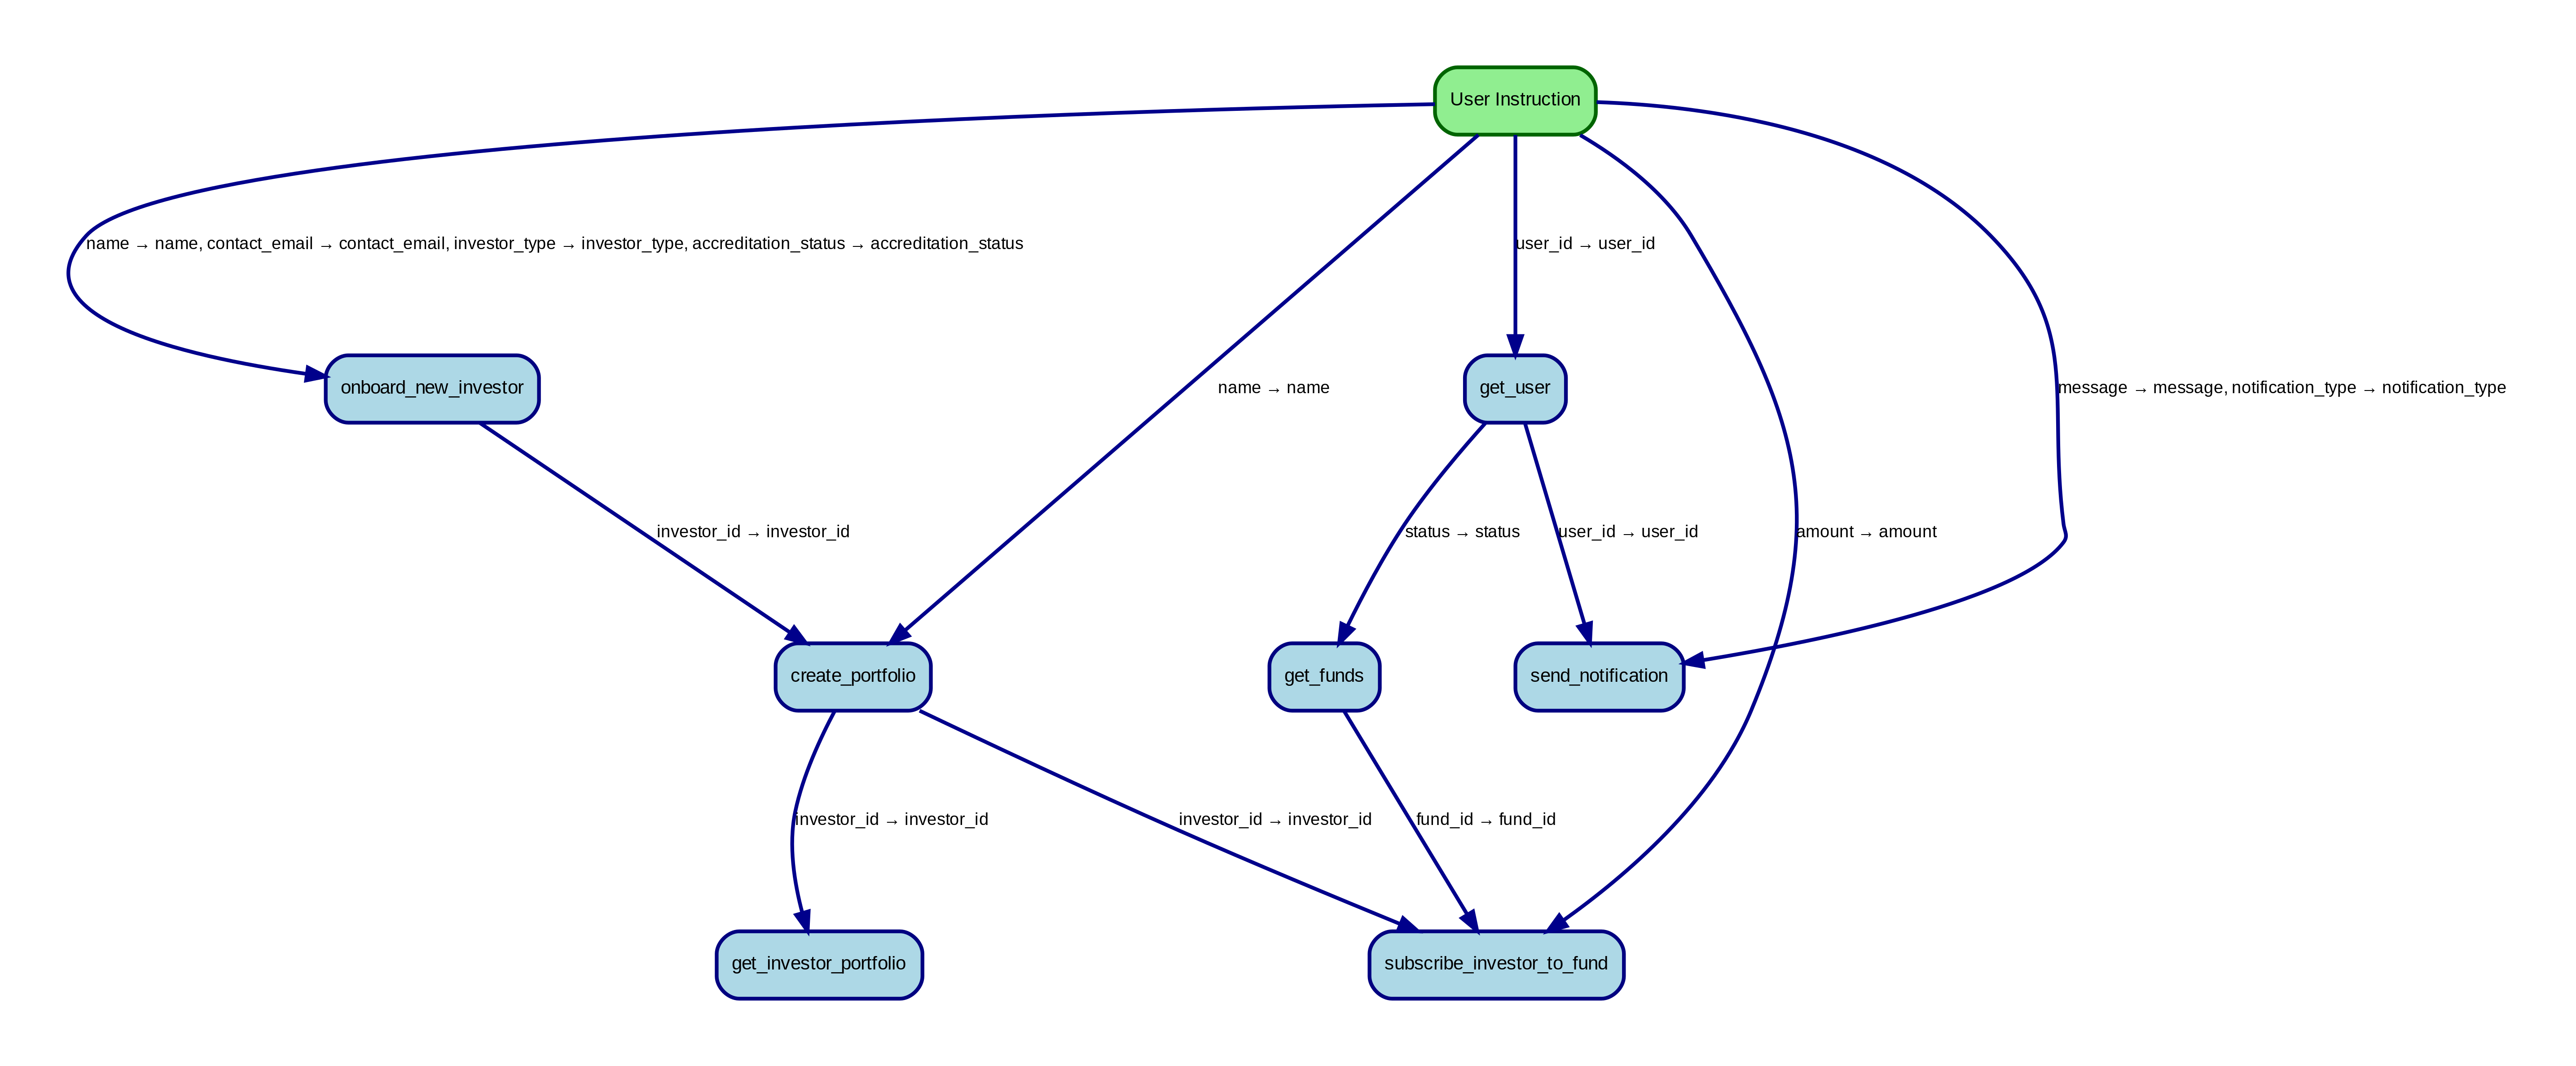

In [5]:
from IPython.display import Image
from IPython.display import display
import base64
import os

# Check if the response contains the expected data
response_data = response.json()
print("Response keys:", response_data.keys())

if 'plot_base64' in response_data and response_data['plot_base64'] is not None:
    plot_base64 = response_data['plot_base64']
    plot_image = base64.b64decode(plot_base64)
    display(Image(data=plot_image))
else:
    print("API Error:", response_data.get('error', 'Unknown error'))
    print("\nLet's check for local example plots...")
    
    # Check for example plots in the example folder
    example_files = [
        "example/example_with_edges.png",
        "example/other_example.png"
    ]
    
    for example_file in example_files:
        if os.path.exists(example_file):
            print(f"\nFound example plot: {example_file}")
            display(Image(filename=example_file))
        else:
            print(f"Example plot not found: {example_file}")